# Diode Characteristic Curve
**Simulating and Plotting the Characteristic Curve of a Diode**

This paper has been created through collaboration with:

**Amin HasanZadeh**  
Contact address and website:
aminhassanzadeh@mail.um.ac.ir


This example demonstrates how to simulate and plot the characteristic curve of a diode, showcasing its behavior under various voltage conditions.

## Theory:

A diode is a semiconductor device created from a PN junction, which consists of two doped layers of silicon.

Before explaining the purpose of doping silicon, let's take a brief look at the atomic structure. An atom consists of an equal number of protons and electrons, a number referred to as Z, which characterizes the atom. Electrons are bound to the nucleus by electromagnetic forces, but they possess varying energy levels due to the mutual repulsion between them. Some electrons are tightly bound, while others, known as valence electrons, are weakly bound. At normal conditions, atoms are electrically neutral. However, under certain temperature and pressure conditions, weakly bound valence electrons can move between neighboring atoms, creating electromagnetic interactions that bind matter together.

Depending on how weakly bound the valence electrons are, a material may act as an insulator or a conductor. Semiconductors, such as silicon, fall between these two categories.

Doping is the process of introducing small amounts of atoms with either more or fewer valence electrons into a silicon layer. Silicon has four valence electrons, so atoms with three or five valence electrons are used for doping. Doping with atoms that have more valence electrons is called N-type (negative), while doping with atoms that have fewer valence electrons is called P-type (positive). 

In an N-type material, the extra electrons do not participate in bonding and are weakly bound to the atoms, increasing conductivity. In a P-type material, there is a shortage of electrons, creating "holes" that act as positive charge carriers. When a P-type layer is combined with an N-type layer, the electrons from the N-type layer diffuse into the P-type layer, creating an equilibrium state known as the depletion region, which acts as a barrier to current flow.

The depletion region behaves like a capacitor and can be controlled by applying a voltage across the PN junction. When a negative voltage is applied, the depletion region widens, allowing only a small current to flow due to thermal agitation. However, if a positive voltage is applied and exceeds a certain threshold, the depletion region is compressed, allowing a significant flow of electrons across the junction.

As a result, a PN junction (diode) can conduct current from the anode to the cathode, but only if a minimum forward bias voltage is applied. If a sufficiently large reverse voltage is applied, the electrostatic force can become strong enough to cause electrons to flow from the cathode to the anode, a phenomenon known as breakdown.

## Simulation:
This code sets up a Python environment for simulating circuits using PySpice, importing necessary libraries for circuit definition, semiconductor modeling, and plotting, while also linking to a local SPICE library.

### Note on SpiceLibrary
The line `spice_library = SpiceLibrary('.')` initializes a SPICE library object, pointing to the current directory (denoted by `'.'`). This means that the script will look for any SPICE models, such as the `1N4148.lib` file, within the same folder as your main script. By copying `1N4148.lib` into this folder, the library becomes accessible for your circuit simulations using PySpice.

In [1]:


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()


from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Spice.Netlist import Circuit
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Unit import *
from PySpice.Physics.SemiConductor import ShockleyDiode

spice_library = SpiceLibrary('.')

### Circuit Definition
To determine the characteristic curve of a diode, the following circuit is required.

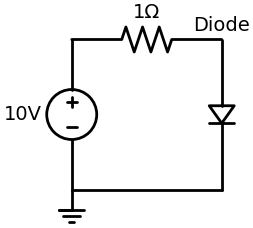

In [12]:
import schemdraw
import schemdraw.elements as elm

with schemdraw.Drawing():
    elm.Resistor().right().label('1Ω')
    elm.Diode().down().label('Diode', loc='right')
    elm.Line().left()
    V = elm.SourceV().up().label('10V', loc='top')
    elm.Ground().at(V.start)

In [2]:
circuit = Circuit('Diode Characteristic Curve')

circuit.include(spice_library['1N4148'])

circuit.V('input', 'in', circuit.gnd, 10@u_V)
circuit.R(1, 'in', 'out', 1@u_Ω)
circuit.X(1 , '1N4148', 'out', circuit.gnd)

2024-09-20 05:41:29,932 - PySpice.Spice.Netlist.Node - Netlist.WARNING - Node name 'in' is a Python keyword


SubCircuitElement X1

### Temperature Analysis

The circuit is simulated at three different temperatures: 0°C, 25°C, and 100°C, to observe the diode's performance under varying thermal conditions.

In [4]:
temperatures = [0, 25, 100]
analyses = {}
for temperature in temperatures:
    simulator = circuit.simulator(temperature=temperature, nominal_temperature=temperature)
    analysis = simulator.dc(Vinput=slice(-2, 5, .01))
    analyses[float(temperature)] = analysis

### Shockley Diode Characteristic Curve

We plot the characteristic curve and compare it to the Shockley diode model:

$$
I_d = I_s \left( e^{\frac{V_d}{n V_T}} - 1 \right)
$$

where $ V_T = \frac{k T}{q} $.

To properly scale the reverse-biased region, we need to apply some adjustments with Matplotlib.

2024-09-20 06:15:20,800 - PySpice.Probe.WaveForm.WaveForm - Unit.WARNING - Should be unit less


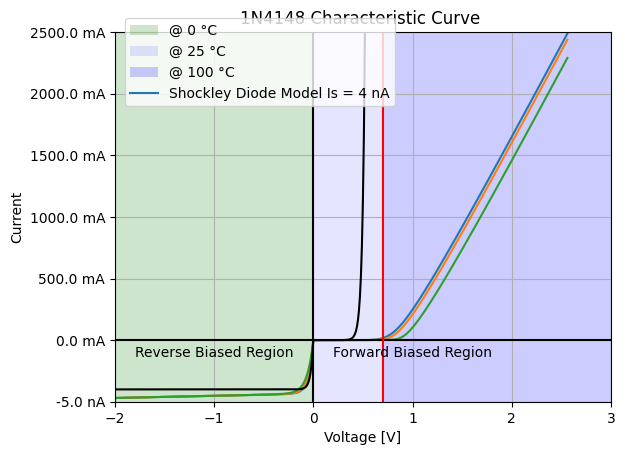

In [14]:
silicon_forward_voltage_threshold = .7  # Define the forward voltage threshold for silicon diodes

shockley_diode = ShockleyDiode(Is=4e-9, degree=25)  # Create a Shockley diode model with saturation current and temperature

def two_scales_tick_formatter(value, position):  # Function to format y-axis ticks for two different current scales
    if value >= 0:
        return '{} mA'.format(value)  # Positive values in mA
    else:
        return '{} nA'.format(value / 100)  # Negative values in nA

formatter = ticker.FuncFormatter(two_scales_tick_formatter)  # Apply the custom formatter to y-axis ticks

figure, ax1 = plt.subplots(1)  # Create a new figure and axis for plotting

ax1.set_title('1N4148 Characteristic Curve ')  # Set the plot title
ax1.set_xlabel('Voltage [V]')  # Label for the x-axis
ax1.set_ylabel('Current')  # Label for the y-axis
ax1.grid()  # Enable grid on the plot
ax1.set_xlim(-2, 3)  # Set limits for the x-axis
ax1.axvspan(-2, 0, facecolor='green', alpha=.2)  # Highlight the reverse biased region
ax1.axvspan(0, silicon_forward_voltage_threshold, facecolor='blue', alpha=.1)  # Highlight the forward biased region up to threshold
ax1.axvspan(silicon_forward_voltage_threshold, 3, facecolor='blue', alpha=.2)  # Highlight the forward region above threshold
ax1.set_ylim(-500, 2500)  # Set limits for the y-axis
ax1.yaxis.set_major_formatter(formatter)  # Apply the custom y-axis formatter

Vd = analyses[25].out  # Get voltage data from the analysis for 25°C
forward_region = Vd >= 0@u_V  # Identify forward-biased region
reverse_region = np.invert(forward_region)  # Identify reverse-biased region
scale = reverse_region * 1e11 + forward_region * 1e3  # Scale currents for plotting

for temperature in temperatures:  # Loop over each temperature for analysis
    analysis = analyses[float(temperature)]  # Get analysis for the current temperature
    ax1.plot(Vd, -analysis.Vinput * scale)  # Plot the current for each temperature

ax1.plot(Vd, shockley_diode.I(Vd) * scale, 'black')  # Plot the Shockley diode model on the same graph
ax1.legend(['@ {} °C'.format(temperature)  # Create a legend with temperature annotations
            for temperature in temperatures] + ['Shockley Diode Model Is = 4 nA'],
           loc=(.02, .8))  # Position the legend

ax1.axvline(x=0, color='black')  # Draw a vertical line at x=0
ax1.axhline(y=0, color='black')  # Draw a horizontal line at y=0
ax1.axvline(x=silicon_forward_voltage_threshold, color='red')  # Draw a vertical line at the forward voltage threshold
ax1.text(-1, -100, 'Reverse Biased Region', ha='center', va='center')  # Label the reverse biased region
ax1.text(1, -100, 'Forward Biased Region', ha='center', va='center')  # Label the forward biased region

plt.show()  # Display the plot


### Dynamic resistanceof Diode

The behavior of a diode in terms of its current-voltage characteristics.

1. **First Equation**:

   $$
   \frac{d I_d}{d V_d} = \frac{1}{n V_T}(I_d + I_s)
   $$

   - This equation describes the derivative of the diode current $ I_d $ with respect to the diode voltage $ V_d $.
   - Here, $ n $ is the ideality factor (typically between 1 and 2), which accounts for the non-ideal behavior of real diodes.
   - $ V_T $ is the thermal voltage, given by $ V_T = \frac{k T}{q} $ (where $ k $ is Boltzmann's constant, $ T $ is the absolute temperature, and $ q $ is the charge of an electron).
   - $ I_s $ is the saturation current, the current that flows through the diode when it is reverse-biased.
   - This equation essentially shows how the current changes with voltage, indicating that the slope (or dynamic resistance) of the diode's characteristic curve is influenced by the current flowing through it.

2. **Second Equation**:
   
   $$
   r_d = \frac{d V_d}{d I_d} \approx \frac{n V_T}{I_d}
   $$
   - This equation defines the dynamic (or small-signal) resistance $ r_d $ of the diode.
   - It represents the change in voltage $ d V_d $ for a change in current $ d I_d $.
   - The approximation indicates that the dynamic resistance can be expressed as a function of the diode's current $ I_d $ and the thermal voltage $ V_T $.
   - Specifically, this implies that as the current $ I_d $ increases, the dynamic resistance $ r_d $ decreases, suggesting that the diode becomes more conductive at higher currents.

Together, these equations help in understanding the diode's behavior, particularly in the forward-biased region, and are useful for analyzing circuits involving diodes.

### Analysis of Diode resistance in T=0 °C

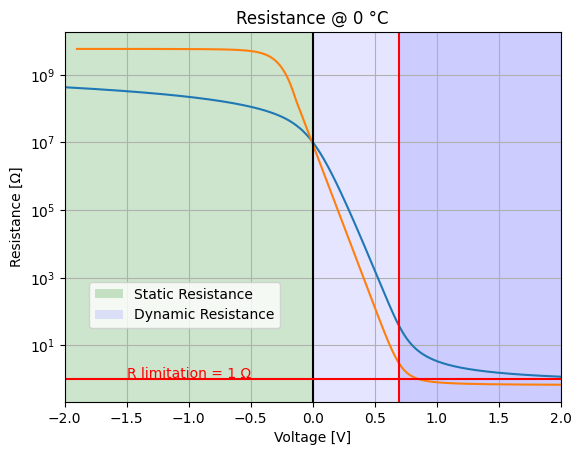

In [15]:
# Resistance @ 0 °C
figure, ax2 = plt.subplots(1)

# Set the title for the resistance plot
ax2.set_title('Resistance @ 0 °C')
ax2.grid()

# Set the x-axis limits
ax2.set_xlim(-2, 2)

# Highlight the regions on the plot
ax2.axvspan(-2, 0, facecolor='green', alpha=.2)  # Reverse biased region
ax2.axvspan(0, silicon_forward_voltage_threshold, facecolor='blue', alpha=.1)  # Forward biased region (below threshold)
ax2.axvspan(silicon_forward_voltage_threshold, 2, facecolor='blue', alpha=.2)  # Forward biased region (above threshold)

# Analyze the circuit at 0 °C
analysis = analyses[0]

# Calculate static resistance (V/I)
static_resistance = -analysis.out / analysis.Vinput

# Calculate dynamic resistance using numerical differentiation
dynamic_resistance = np.diff(-analysis.out) / np.diff(analysis.Vinput)

# Plot static resistance on a logarithmic scale
ax2.semilogy(analysis.out, static_resistance, base=10)

# Plot dynamic resistance on a logarithmic scale, excluding first few points for better clarity
ax2.semilogy(analysis.out[10:-1], dynamic_resistance[10:], base=10)

# Draw vertical lines for reference
ax2.axvline(x=0, color='black')  # Line at zero voltage
ax2.axvline(x=silicon_forward_voltage_threshold, color='red')  # Line at forward voltage threshold
ax2.axhline(y=1, color='red')  # Horizontal line at 1 Ω

# Add text annotation for resistance limitation
ax2.text(-1.5, 1.1, 'R limitation = 1 Ω', color='red')

# Create a legend for the plot
ax2.legend(['{} Resistance'.format(x) for x in ('Static', 'Dynamic')], loc=(.05,.2))

# Set axis labels
ax2.set_xlabel('Voltage [V]')
ax2.set_ylabel('Resistance [Ω]')

# Display the plot
plt.show()


### Analysis of Diode resistance in T=25 °C

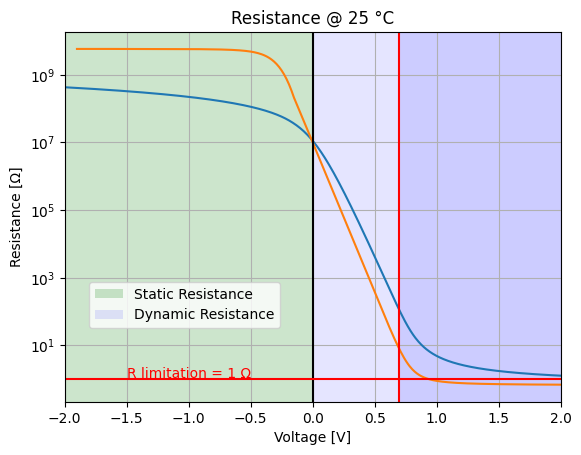

In [7]:
#Resistance @ 25 °C

figure, ax3 = plt.subplots(1)

ax3.set_title('Resistance @ 25 °C')
ax3.grid()
ax3.set_xlim(-2, 2)
ax3.axvspan(-2, 0, facecolor='green', alpha=.2)
ax3.axvspan(0, silicon_forward_voltage_threshold, facecolor='blue', alpha=.1)
ax3.axvspan(silicon_forward_voltage_threshold, 2, facecolor='blue', alpha=.2)
analysis = analyses[25]
static_resistance = -analysis.out / analysis.Vinput
dynamic_resistance = np.diff(-analysis.out) / np.diff(analysis.Vinput)
ax3.semilogy(analysis.out, static_resistance, base=10)
ax3.semilogy(analysis.out[10:-1], dynamic_resistance[10:], base=10)
ax3.axvline(x=0, color='black')
ax3.axvline(x=silicon_forward_voltage_threshold, color='red')
ax3.axhline(y=1, color='red')
ax3.text(-1.5, 1.1, 'R limitation = 1 Ω', color='red')
ax3.legend(['{} Resistance'.format(x) for x in ('Static', 'Dynamic')], loc=(.05,.2))
ax3.set_xlabel('Voltage [V]')
ax3.set_ylabel('Resistance [Ω]')

plt.show()


### Analysis of Diode resistance in T=100 °C

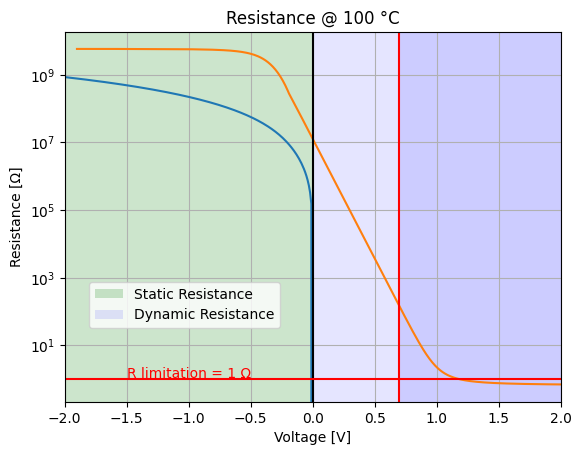

In [10]:
#Resistance @ 100 °C

figure, ax4 = plt.subplots(1)

ax4.set_title('Resistance @ 100 °C')
ax4.grid()
ax4.set_xlim(-2, 2)
ax4.axvspan(-2, 0, facecolor='green', alpha=.2)
ax4.axvspan(0, silicon_forward_voltage_threshold, facecolor='blue', alpha=.1)
ax4.axvspan(silicon_forward_voltage_threshold, 2, facecolor='blue', alpha=.2)
analysis = analyses[100]
static_resistance = -analysis.out / analysis.Vinput
dynamic_resistance = np.diff(-analysis.out) / np.diff(analysis.Vinput)
ax4.semilogy(analysis.out, static_resistance, base=10)
ax4.semilogy(analysis.out[10:-1], dynamic_resistance[10:], base=10)
ax4.axvline(x=0, color='black')
ax4.axvline(x=silicon_forward_voltage_threshold, color='red')
ax4.axhline(y=1, color='red')
ax4.text(-1.5, 1.1, 'R limitation = 1 Ω', color='red')
ax4.legend(['{} Resistance'.format(x) for x in ('Static', 'Dynamic')], loc=(.05,.2))
ax4.set_xlabel('Voltage [V]')
ax4.set_ylabel('Resistance [Ω]')

plt.show()

### Conclusion
We observe that the forward voltage threshold increases with temperature.